# Predictive model attemp


## Imports

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_cleaning import load_data, drop_index_column



## Load the Dataset

In [17]:
df = load_data('../data/raw/ncdatachallenge-2021-v1.csv')
df = drop_index_column(df)
df.head()

INFO: 'Unnamed: 0' column dropped.


,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## RandomForests

### Prepare the data

In [18]:
model_cols = [
    'n_cycles_trying', 'age', 'bmi', 'dedication', 'average_cycle_length',
    'cycle_length_std', 'intercourse_frequency',
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
]
pregnant_df = df[df['outcome'] == 'pregnant'].copy()
pregnant_df = pregnant_df[model_cols].dropna().copy()

# One-hot encode categorical variables
pregnant_df = pd.get_dummies(pregnant_df, columns=[
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
], drop_first=True)
bool_cols = pregnant_df.select_dtypes(include='bool').columns
pregnant_df[bool_cols] = pregnant_df[bool_cols].astype(int)
# Confirm all are numeric
assert pregnant_df.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()

### Train the model

In [19]:
X = pregnant_df.drop(columns='n_cycles_trying')
y = pregnant_df['n_cycles_trying']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Predict the model accuracy

In [20]:
rf_preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, rf_preds)
rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
r2 = r2_score(y_test, rf_preds)
mape = mean_absolute_percentage_error(y_test, rf_preds)

mae, rmse, r2, mape

(1.9615131578947367,
 np.float64(2.5608611575837243),
 0.08375758162148428,
 0.9054708425711716)

### Shap values

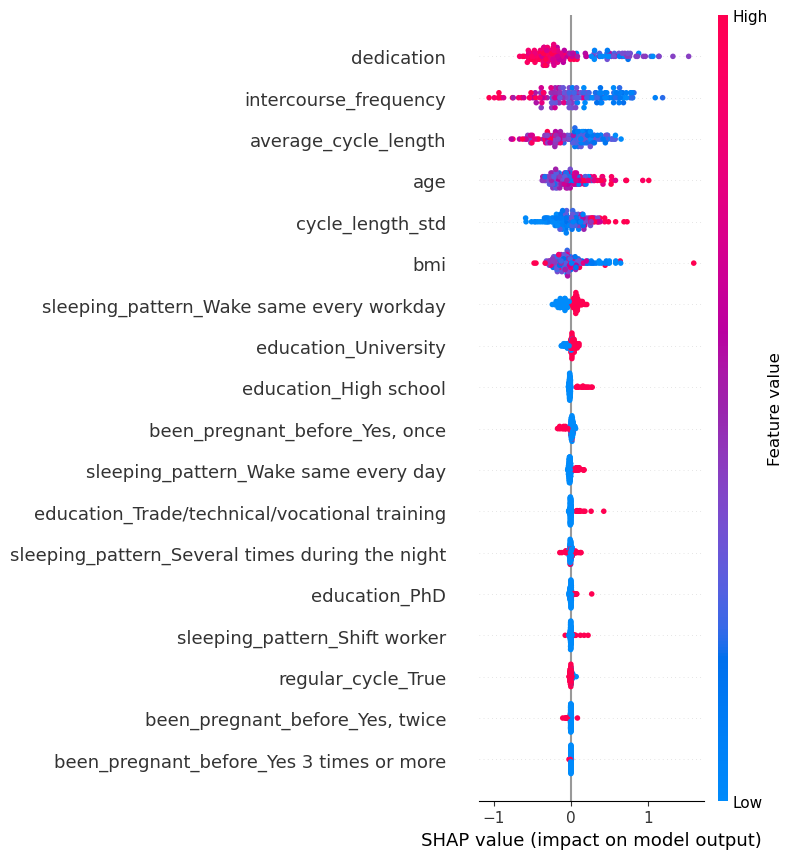

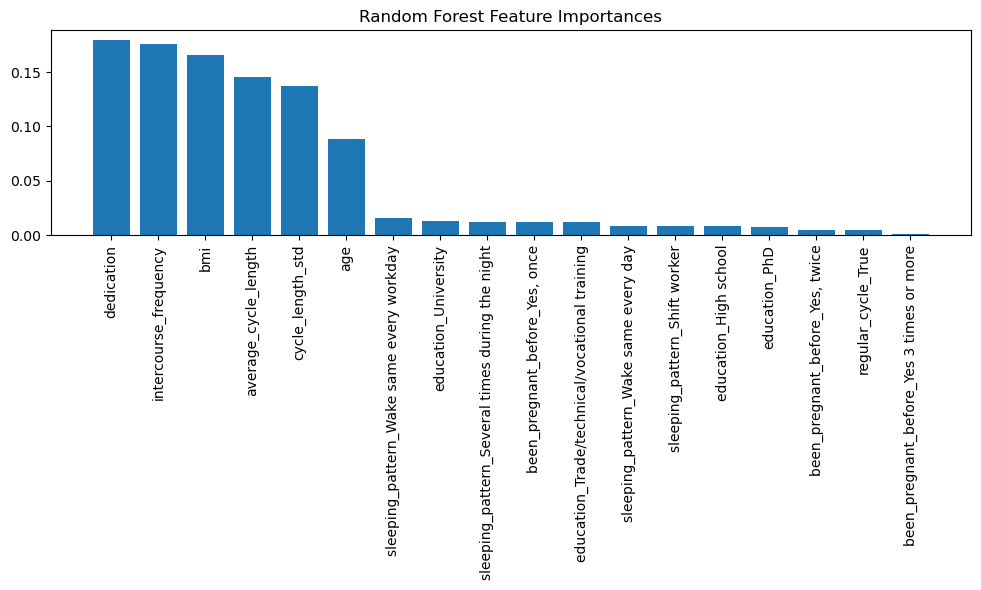

In [21]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# Plot feature importances from RF directly
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=90)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()